In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import Dataset

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from tqdm import tqdm

from tqdm.notebook import tqdm
import numpy as np

from sklearn.model_selection import ParameterGrid

from torchinfo import summary

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Фиксируем seed

In [4]:
random_seed = 48
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

## Dataset MNIST-letters

In [5]:
transform = torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])

train_data = datasets.EMNIST(
    root='data',
    split='letters',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.EMNIST(
    root='data',
    split='letters',
    train=False,
    download=True,
    transform=transform
)

In [6]:
print(*train_data.classes)

N/A a b c d e f g h i j k l m n o p q r s t u v w x y z


In [7]:
n_classes = len(train_data.classes)
n_classes

27

In [8]:
image_size = train_data[0][0].size()[-1]
image_size

28

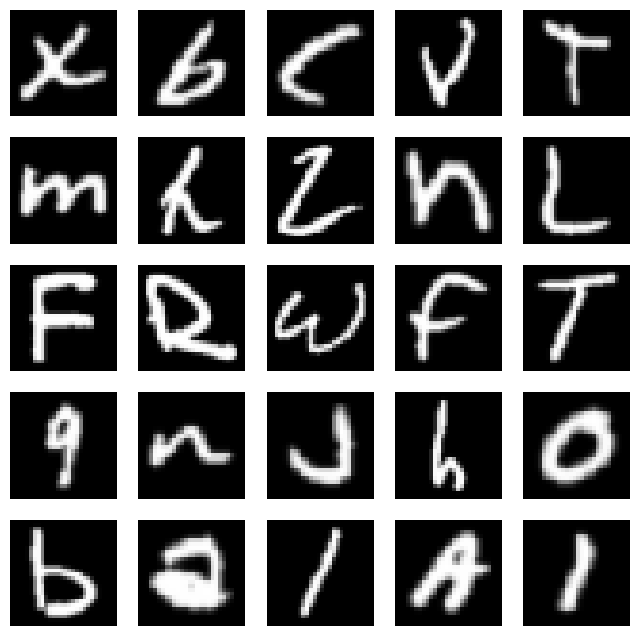

In [9]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Обучение модели (код с семинара)

In [10]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()

    output = model(x_batch.to(device))

    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [11]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss/total

In [12]:
def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True),
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))

        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})

In [13]:
def train_quality(model,
                  dataset,
                  loss_function,
                  batch_size):

    batch_generator = torch.utils.data.DataLoader(dataset=dataset,
                                                  batch_size=batch_size)

    pred = []
    real = []
    test_loss = 0

    for it, (x_batch, y_batch) in enumerate(batch_generator):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)

        test_loss += loss_function(output, y_batch).cpu().item() * len(x_batch)

        pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
        real.extend(y_batch.cpu().numpy().tolist())

    test_loss /= len(dataset)

    return test_loss, pred, real

## Tensorboard callback (~код с семинара)

In [14]:
class tensorboard_callback:
    def __init__(self, writer, dataset, loss_function, delimeter=100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)

        if self.step % self.delimeter == 0:
            self.writer.add_graph(model, self.dataset[0][0].view(1, 1, 28, 28).to(model.device))
            test_loss, pred, real = train_quality(model=model, dataset=self.dataset,
                                                  loss_function=self.loss_function, batch_size=self.batch_size)
            self.writer.add_scalar('LOSS/test', test_loss, self.step)

    def __call__(self, model, loss):
        return self.forward(model, loss)

## Модель

In [76]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
            
    def __init__(self,     
                 n_layers = 1,       #  числа слоев;
                 kernel_size = 3,    # размера ядра;
                 max_pool = False,   # от пулинга;
                 batch_norm = False, # добавления BatchNorm;
                 dropout = 0.0):     # параметра dropout.
        
        super().__init__()

        self.size = image_size
        self.n_channels = 1
        self.layers = torch.nn.Sequential()

        for layer in range(n_layers):
            self.layers.add_module(f'Conv2d[{layer}]', torch.nn.Conv2d(self.n_channels, 
                                                                       self.n_channels * 4, 
                                                                       kernel_size=kernel_size))
            self.n_channels *= 4
            self.size -= (kernel_size - 1)

            if batch_norm:
                self.layers.add_module(f'BatchNorm2d[{layer}]', torch.nn.BatchNorm2d(self.n_channels))

            self.layers.add_module(f'ReLU[{layer}]', torch.nn.ReLU())

            if max_pool:
                self.layers.add_module(f'MaxPool2d[{layer}]', torch.nn.MaxPool2d(kernel_size=2))
                self.size //= 2

        self.layers.add_module('Flatten[0]', torch.nn.Flatten())
        self.layers.add_module('Dropout[0]', torch.nn.Dropout(dropout))
        in_features = int(self.n_channels * self.size**2)
        print(f'n_features {in_features}')
        self.layers.add_module('Linear[0]', torch.nn.Linear(in_features, n_classes))

    def forward(self, input):
        return self.layers(input)

In [16]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [17]:
batch_size = 128

In [77]:
grid = ParameterGrid({
    'n_layers': [2],
    'kernel_size': [3, 7],
    'max_pool': [True, False],
    'batch_norm': [False, True],
    'dropout': [0.0, 0.5],
})

scores = dict()

for params in tqdm(grid):
    print(str(params))

    # Create model
    model = CNN(**params)
    mod = model.to(device)
    
    writer = SummaryWriter(f'runs/{str(params)}')
    callback = tensorboard_callback(writer, test_data, loss_function, batch_size=batch_size, delimeter=10)

    trainer(count_of_epoch=1,
            batch_size=batch_size,
            dataset=train_data,
            model=model,
            loss_function=loss_function,
            optimizer=optimizer,
            lr=0.001,
            callback=callback)


  0%|          | 0/16 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'max_pool': True, 'n_layers': 2}
n_features 400


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'max_pool': False, 'n_layers': 2}
n_features 9216


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 7, 'max_pool': True, 'n_layers': 2}
n_features 64


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 7, 'max_pool': False, 'n_layers': 2}
n_features 4096


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 3, 'max_pool': True, 'n_layers': 2}
n_features 400


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 3, 'max_pool': False, 'n_layers': 2}
n_features 9216


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 7, 'max_pool': True, 'n_layers': 2}
n_features 64


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 7, 'max_pool': False, 'n_layers': 2}
n_features 4096


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'max_pool': True, 'n_layers': 2}
n_features 400


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'max_pool': False, 'n_layers': 2}
n_features 9216


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 7, 'max_pool': True, 'n_layers': 2}
n_features 64


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 7, 'max_pool': False, 'n_layers': 2}
n_features 4096


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 3, 'max_pool': True, 'n_layers': 2}
n_features 400


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 3, 'max_pool': False, 'n_layers': 2}
n_features 9216


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 7, 'max_pool': True, 'n_layers': 2}
n_features 64


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 7, 'max_pool': False, 'n_layers': 2}
n_features 4096


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

## Выводы:

Реализована сверточная нейронная сеть, обученная на EMNIST-letters датасете.

Также реализован Grid Search по гиперпараметрам:
- размер ядра Conv2d
- число слоев CNN
- Max Pooling
- Batch Norm
- Dropout

Наилучшие результаты показали CNN с двумя слоями, без Batch Norm и Max Pooling и в не зависимости от размера ядра (Dropout также практически не влияет).

Неожиданно, CNN с Batch Norm и Max Pooling оказались сильно неточными (даже хуже сети с одним слоем).

Остальные комбинации гиперпараметров приводят к промежуточным результатам.
